# T1 CC6204 Deep Learning

Por: Álvaro Morales T.

26-09-2023

Trabajado en local con CUDA y PyTorch

SPECS:

**CPU**: AMD Ryzen 7 5700XX (8 Core) @4.5 GHz.

**GPU**: NVIDIA GeForce RTX 3060 Ti (8GB VRAM).

16 GB RAM @ 3200 MHz.

In [585]:
!nvcc --version
from torch import __version__ as torch_version
print("Pytorch version: {}".format(torch_version))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Pytorch version: 2.0.1+cu118


# **CC6204 - Deep Learning**

## **Predicción de riesgo de diabetes en etapas tempranas**

En esta tarea vas a desarrollar un modelo de aprendizaje que sea capaz de  determinar si una persona tiene riesgo de paceder diabetes en un futuro. Los datos han sido coleccionados a través de encuestas a pacientes en el Sylhet Diabetes Hospital en Bangladesh. Los datos han sido curados y verificados por profesionales de la salud, por lo que son confiables para crear un modelo de aprendizaje.

Primero vamos a importar los paquetes necesarios para trabajar en estos datos.

In [482]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



## **Descarga de archivo de datos**
Los datos están disponibles en un archivo CSV que contiene 520 muestras de 17 atributos. Los atributos son:

*   Age: numérico
*   Género: \[Male, Female\]
*   Polyuria
*   Polydipsia
*   sudden weight loss
*   weakness
*   Polyphagia
*   Genital thrush
*   visual blurring
*   Itching
*   Irritability
*   delayed healing
*   partial paresis
*   muscle stiffness
*   Alopecia
*   Obesity
*   Class: \[Positive, Negative\]

Todos los atributos descritos sin valores tienen el conjunto \[Yes, No\].

En la siguiente celda de código, descargamos el archivo y lo leemos con Pandas. Finalmente, visualizamos algunos datos del conjunto.



In [483]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
dataset_path = 'diabetes_data_upload.csv'

In [484]:
import csv

with open('diabetes_data_upload.csv') as inp, open('temp.csv', 'w') as out:
    reader = csv.reader(inp)
    writer = csv.writer(out, delimiter=',')
    #No need to use `insert(), `append()` simply use `+` to concatenate two lists.
    writer.writerow(['ID'] + next(reader))
    #Iterate over enumerate object of reader and pass the starting index as 1.
    writer.writerows([i] + row for i, row in enumerate(reader, 1))

In [485]:
column_names = ['Age','Gender','Polyuria','Polydipsia','sudden weight loss',
                'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring','Itching', 'Irritability', 'delayed healing',
                'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, header=1)

dataset = raw_dataset.copy()
dataset.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
1,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
2,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
3,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
4,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive


# **Pre-procesamiento del conjunto de datos**
El conjunto de datos es variado. El atributo "Age" es el único atributo numérico. Todos los demás atributos son nominales. Para procesar los datos nominales en una red neuronal, es mejor convertirlos a una representación numérica. En el siguiente ejemplo transformamos el atributo "Gender" con valores nominales "Female" y "Male" a valores 1.0 y 0.0, respectivamente.

Del mismo modo, cambiamos los valores nominales de todos los atributos a valores 0.0 y 1.0.

In [486]:
gender = dataset.pop('Gender')
dataset['gender'] = (gender == 'Female')*1.0

column_class = dataset.pop('class')
dataset['class'] = (column_class=='Positive')*1.0

for column in column_names:
  if column not in ['Gender', 'class', 'Age']:
    column_class = dataset.pop(column)
    dataset[column] = (column_class=='Yes')*1.0

# Prueba mostrando parte de la data para ver si tu conversión se hizo correctamente
dataset.tail()


,Age,gender,class,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
514,39,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
515,48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
516,58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
517,32,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
518,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora normalizamos el atributo "Age" y dividimos la data en conjunto de entrenamiento y conjunto de test. Esta división es siempre necesaria para poder probar si tu modelo de aprendizaje ha aprendido a generalizar con datos que no pertenecen al conjunto de entrenamiento.

In [487]:
max_age = dataset["Age"].max()
dataset["Age"] = dataset["Age"] / max_age
dataset.tail()


#80% de datos para train y 20% de datos para test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('class')
test_labels = test_dataset.pop('class')


In [488]:
#Convertimos todo a arrays Numpy
X_train = train_dataset.to_numpy()
X_test = test_dataset.to_numpy()

Y_train = train_labels.to_numpy()
Y_test = test_labels.to_numpy()

Y_train = Y_train[:,None]
Y_test = Y_test[:,None]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(415, 16)
(415, 1)
(104, 16)
(104, 1)


# **Parte 1**
Diseña y entrena un perceptrón multicapa con la data de arriba. Intenta que tu modelo alcance el mayor accuracy de test posible (ojalá por encima del 93%). Para este primer experimento puedes usar la implementación de MLP vista en clase (basada en Numpy) ó puedes usar algún framework como Tensorflow o Pytorch si es que deseas. Hay que tener en cuenta algunas consideraciones para este primer experimento:



*   Usar gradiente descendiente estocástico con un tamaño de mini-batch de 20.
*   Usar learning rate de 0.01.
*  Los mini-batches NO se generan de manera aleatoria.

Graficar la función de loss con respecto a las épocas.

In [489]:
# usaré torch por comodidad
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [490]:
# random stuff
import random
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [491]:
# Hyperparámetros
BATCH_SIZE = 20
LEARNING_RATE = 0.01
EPOCHS = 300 # elegido al ojo

In [492]:
# separemos nustros datos train en train y validation
VALID_RATIO = 0.1
N = len(X_train)
N_valid = int(N*VALID_RATIO)
N_train = N - N_valid

# creamos los datasets
X_train, X_valid = np.split(X_train, [N_train])
Y_train, Y_valid = np.split(Y_train, [N_train])

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape) # son poquitos, pero al final sí ayudaron a que
print(Y_valid.shape) # el modelo aprenda un poco más rápido

(374, 16)
(374, 1)
(41, 16)
(41, 1)


In [493]:
# zippear la data
train_data = list(zip(X_train, Y_train))
valid_data = list(zip(X_valid, Y_valid))
test_data = list(zip(X_test, Y_test))

In [494]:
# preparamos la data en iteradores para torch
# ojo: no hacemos shuffle porque dijimos que los batches no serían aleatorios
train_iterator = data.DataLoader(train_data, shuffle=False, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [495]:
# nuestra MLP
class MLP(nn.Module):

    # constructor
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # ojo: los datos quedaron con dtype= float64.
        # para que no nos de un error de tipo despúes, hay que decirle a torch que
        # los parámetros de la red también son float64 (el default de torch es float32)
        self.fc1 = nn.Linear(input_dim, 320, dtype=torch.float64)
        self.fc2 = nn.Linear(320, 160, dtype=torch.float64)
        self.fc3 = nn.Linear(160, output_dim, dtype=torch.float64)
        # hagamos un conteo de parámetros:
        # nuestro input dim es 16, y nuestro output dim es 1.
        # las hidden layers las elejí al ojo.
        # -> 16*320 + 320 + 320*160 + 160 + 160*1 + 1 = 56 961 parámetros
        #    w1       b1    w2        b2    w3      b3

    # forward
    def forward(self, input):
        batch_size = input.shape[0]
        input = input.view(batch_size, -1)
        # ReLU en las hidden, sigmoid en la última
        h_1 = F.relu(self.fc1(input))
        h_2 = F.relu(self.fc2(h_1))
        # tal vez sea mejor idea solo devolver y_pred = self.fc3(h_2)
        # y aplicar sigmoide al momento de evaluar, en calculate_accuracy
        # pero por ahora esto sirve.
        y_pred = torch.sigmoid(self.fc3(h_2))
        return y_pred, h_2

In [496]:
# crear el modelo
INPUT_DIM = 16
OUTPUT_DIM = 1
model = MLP(INPUT_DIM, OUTPUT_DIM)

In [497]:
# crear el optimizador (dijimos que sería Gradiente Descendente Estocástico)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [498]:
# criterio de loss. Usemos Binary Cross Entropy
criterion = nn.BCEWithLogitsLoss()

In [499]:
# usemos la GPU si se puede
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [500]:
# mover el modelo a la GPU
model = model.to(device)
criterion = criterion.to(device)

In [501]:
# función para calcular la accuracy
def calculate_accuracy(y_pred, y):
  y_pred = torch.round(y_pred)
  correct = (y_pred == y).float()
  acc = correct.sum() / len(correct)
  return acc

In [502]:
# función de entrenamiento
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation  
  model.train()
  
  #Training loop
  for (x, y) in iterator:
    x = x.to(device) #Data
    y = y.to(device) #Labels
        
    optimizer.zero_grad() #Clean gradients
             
    y_pred, _ = model(x) #Feed the network with data
        
    loss = criterion(y_pred, y) #Compute the loss
       
    acc = calculate_accuracy(y_pred, y) #Compute the accuracy
        
    loss.backward() #Compute gradients
        
    optimizer.step() #Apply update rules
        
    epoch_loss += loss.item()
    epoch_acc += acc.item()
        
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [503]:
# función de evaluación

def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for 
  #training (dropout for instance)    
  model.eval()
    
  with torch.no_grad(): #disable the autograd engine (save computation and memory)
        
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)

      y_pred, _ = model(x)

      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [504]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [505]:
# Entreneamiento
import time

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    
  start_time = time.time()

  #Train + validation cycles  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  # save the losses for the plot later
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
    
  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')
    
  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.668 | Train Acc: 38.57%
	 Val. Loss: 0.602 |  Val. Acc: 25.00%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.667 | Train Acc: 45.94%
	 Val. Loss: 0.600 |  Val. Acc: 26.67%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 52.52%
	 Val. Loss: 0.599 |  Val. Acc: 33.33%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.665 | Train Acc: 65.64%
	 Val. Loss: 0.598 |  Val. Acc: 45.00%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 74.21%
	 Val. Loss: 0.597 |  Val. Acc: 51.67%


Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 78.65%
	 Val. Loss: 0.596 |  Val. Acc: 86.67%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.663 | Train Acc: 81.02%
	 Val. Loss: 0.595 |  Val. Acc: 85.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.662 | Train Acc: 82.33%
	 Val. Loss: 0.594 |  Val. Acc: 85.00%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.661 | Train Acc: 82.18%
	 Val. Loss: 0.593 |  Val. Acc: 86.67%
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 0.660 | Train Acc: 81.39%
	 Val. Loss: 0.592 |  Val. Acc: 86.67%
Epoch: 11 | Epoch Time: 0m 0s
	Train Loss: 0.660 | Train Acc: 82.82%
	 Val. Loss: 0.590 |  Val. Acc: 86.67%
Epoch: 12 | Epoch Time: 0m 0s
	Train Loss: 0.659 | Train Acc: 82.82%
	 Val. Loss: 0.589 |  Val. Acc: 86.67%
Epoch: 13 | Epoch Time: 0m 0s
	Train Loss: 0.658 | Train Acc: 82.29%
	 Val. Loss: 0.588 |  Val. Acc: 88.33%
Epoch: 14 | Epoch Time: 0m 0s
	Train Loss: 0.657 | Train Acc: 82.56%
	 Val. Loss: 0.587 |  Val. Acc: 88.33%
Epoch: 15 | Epoch Time: 0m 0

In [506]:
#Cargar el mejor modelo
model.load_state_dict(torch.load('saved-model.pt'))

test_loss , test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.494 | Test Acc: 93.33%


Nice.

A penas, pero llega a un acc > 93%

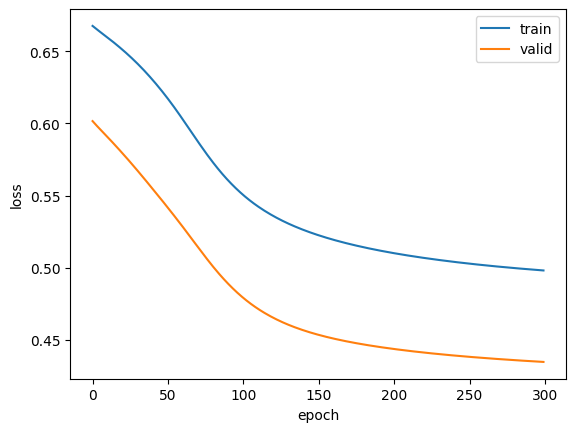

In [508]:
# ahora grafiquemos la función de loss c/r a los epochs:
plt.plot(range(EPOCHS), train_losses, label='train')
plt.plot(range(EPOCHS), valid_losses, label='valid')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


Ciertamente desciende, pero cada vez cuesta más y más. ¿Será por el tamaño de los batches? ¿El learning rate? Veamos...

# **Parte 2**
Intenta cambiar el tamaño de los mini-batches. Como casos extremos usa m=1 (mini-batches de tamaño 1) y m=n(1 solo mini-batch con todos los datos). Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [510]:
# guardemos esto para despues...
train_losses_batch20 = train_losses
valid_losses_batch20 = valid_losses

In [511]:
# probemos con batches de 1
BATCH_SIZE = 1

In [512]:
# creamos el MLP de nuevo y lo entrenamos de la misma forma, pero con estos nuevos batches
model = MLP(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    
  start_time = time.time()

  #Train + validation cycles  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  # save the losses for the plot later
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
    
  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')
    
  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

#Cargar el mejor modelo
model.load_state_dict(torch.load('saved-model.pt'))

test_loss , test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.669 | Train Acc: 58.80%
	 Val. Loss: 0.598 |  Val. Acc: 73.33%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.668 | Train Acc: 58.80%
	 Val. Loss: 0.597 |  Val. Acc: 75.00%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.667 | Train Acc: 61.02%
	 Val. Loss: 0.596 |  Val. Acc: 75.00%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.667 | Train Acc: 61.28%
	 Val. Loss: 0.595 |  Val. Acc: 75.00%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 61.28%
	 Val. Loss: 0.595 |  Val. Acc: 75.00%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 61.28%
	 Val. Loss: 0.594 |  Val. Acc: 75.00%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.665 | Train Acc: 61.28%
	 Val. Loss: 0.593 |  Val. Acc: 75.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 61.28%
	 Val. Loss: 0.593 |  Val. Acc: 75.00%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 62.07%
	 Val. Loss: 0.592 |  Val. Acc: 75.00%
Epoch: 10 | Epoch Time: 0m 0

In [513]:
# guardamos para después...
train_losses_batch1 = train_losses
valid_losses_batch1 = valid_losses

In [514]:
# Ahora vamos al otro extremo. 1 batch con todos los datos
BATCH_SIZE = N_train

In [515]:
# creamos el MLP de nuevo y lo entrenamos de la misma forma, pero con estos nuevos batches
model = MLP(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    
  start_time = time.time()

  #Train + validation cycles  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  # save the losses for the plot later
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
    
  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')
    
  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

#Cargar el mejor modelo
model.load_state_dict(torch.load('saved-model.pt'))

test_loss , test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.670 | Train Acc: 38.72%
	 Val. Loss: 0.607 |  Val. Acc: 25.00%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.670 | Train Acc: 38.72%
	 Val. Loss: 0.606 |  Val. Acc: 25.00%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.669 | Train Acc: 38.72%
	 Val. Loss: 0.605 |  Val. Acc: 25.00%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.668 | Train Acc: 38.72%
	 Val. Loss: 0.603 |  Val. Acc: 25.00%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.667 | Train Acc: 38.72%
	 Val. Loss: 0.602 |  Val. Acc: 26.67%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 44.77%
	 Val. Loss: 0.601 |  Val. Acc: 30.00%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.665 | Train Acc: 51.20%
	 Val. Loss: 0.600 |  Val. Acc: 35.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 58.95%
	 Val. Loss: 0.598 |  Val. Acc: 40.00%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.663 | Train Acc: 64.21%
	 Val. Loss: 0.597 |  Val. Acc: 45.00%
Epoch: 10 | Epoch Time: 0m 0

In [516]:
# guardamos estos losses también
train_losses_batchall = train_losses
valid_losses_batchall = valid_losses

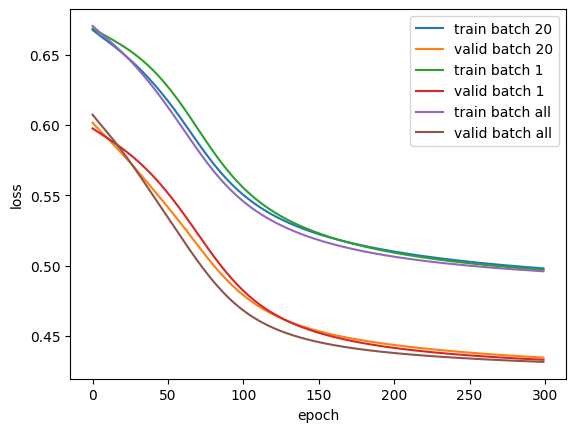

In [517]:
# ahora graficamos los 3 juntos
plt.plot(range(EPOCHS), train_losses_batch20, label='train batch 20')
plt.plot(range(EPOCHS), valid_losses_batch20, label='valid batch 20')
plt.plot(range(EPOCHS), train_losses_batch1, label='train batch 1')
plt.plot(range(EPOCHS), valid_losses_batch1, label='valid batch 1')
plt.plot(range(EPOCHS), train_losses_batchall, label='train batch all')
plt.plot(range(EPOCHS), valid_losses_batchall, label='valid batch all')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


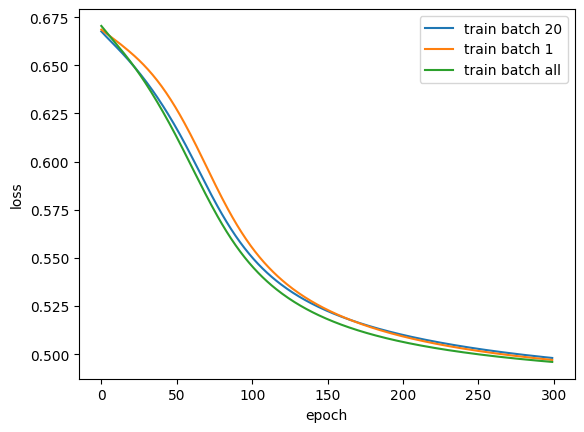

In [518]:
# quitemos los losses de validación para ver más de cerca
plt.plot(range(EPOCHS), train_losses_batch20, label='train batch 20')
plt.plot(range(EPOCHS), train_losses_batch1, label='train batch 1')
plt.plot(range(EPOCHS), train_losses_batchall, label='train batch all')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

Fijándonos en los primeros ~150 epochs, parece ser que batches más grandes parecen hacer que el modelo aprenda más rápido. Y viceversa, el run con mini batches de 1 tardó considerablemente más en aprender. Pero notemos que eventualmente, aunque los 3 runs terminaron estancándose más o menos en el mismo valor, el batch con todos los datos siempre mantuvo la delantera y aprendió mejor que los otros 2, mientras que el de tamaño 1, si bien inicialmente era el peor, eventualmente alcanzó y superó al de 20.

¿Por qué ocurre esto? A priori, por rendimiento nos conviene más usar batches más grandes, y el problema que nos juega en contra para hacer esto es la memoria disponible, pero la idea siendo que con batches más grandes podemos aprovechar mejor la paralización en la GPU y correr el modelo más rápido. Y esto es exactamente lo que vemos. ¿Pero por qué debería el tamaño del batch afectar qué tan bien aprende el modelo?

Una pregunta más fundamental es, ¿Por qué el modelo se estanca, para empezar? Esto se debe a **overfitting**. Como no tenemos muchos datos, el modelo empieza a aprender, en cada epoch, patrones que solo aplican a los datos de entrenamiento, y que no necesariamente se aplican en general. Se puede pensar esto como si el modelo estuviera "memorizando" en vez de "aprendiendo". En cada epoch el modelo se ajusta más y más a los datos de entrenamiento, pero eventualmente llega a un punto en que no puede mejorar más, porque ya no hay más patrones que aprender. Nos quedamos sin información nueva. Y como estos patrones no necesariamente se aplican en general, el modelo no puede mejorar más.

¿Y que tiene que ver el tamaño de los batch con esto? Notamos que no mucho, pero que definitivamente hay un efecto. Parece ser que con un batch size suficientemente grande, se logra reducir ligeramente el overfitting, y se alcanza un mejor aprendizaje. Esto tiene sentido, ya que le pasamos toda la data de entrenamiento de una, haciendo más probable que, localmente, el modelo aprenda patrones más generales, y no patrones que solo apliquen a un subconjunto de datos.

Con un batch size más pequeño, como el de 20, el modelo podría correr el riesgo de aprender patrones de conjuntos pequeños de datos.

Y con el batch size de 1, el otro caso extremo, como no pueden haber patrones en 1 solo dato, en cierta forma se asemeja un poco más al caso donde el modelo aprende de todos los datos a la vez. El problema es que al ser un batch size tan pequeño, el modelo aprende más lento por no poder aprovechar la paralelización. Esto explicaría por qué el batch size de 1 es inicialmente peor, pero eventualmente supera al de 20 y se acerca al de todos los datos.

# **Parte 3**
Intenta cambiar el learning rate. Como casos extremos usa lr = 0.5 y lr = 0.000001. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [541]:
# Seamos consistentes con el batch size
BATCH_SIZE = 20

# hagamos un run con learning rate 0.01 (lo que teníamos)
LEARNING_RATE = 0.01

In [542]:
model = MLP(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    
  start_time = time.time()

  #Train + validation cycles  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  # save the losses for the plot later
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
    
  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')
    
  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 61.28%
	 Val. Loss: 0.593 |  Val. Acc: 75.00%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 61.28%
	 Val. Loss: 0.593 |  Val. Acc: 75.00%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.665 | Train Acc: 61.28%
	 Val. Loss: 0.592 |  Val. Acc: 75.00%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 61.28%
	 Val. Loss: 0.591 |  Val. Acc: 75.00%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 61.28%
	 Val. Loss: 0.590 |  Val. Acc: 75.00%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.663 | Train Acc: 61.28%
	 Val. Loss: 0.589 |  Val. Acc: 75.00%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.663 | Train Acc: 61.28%
	 Val. Loss: 0.589 |  Val. Acc: 75.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.662 | Train Acc: 61.28%
	 Val. Loss: 0.588 |  Val. Acc: 75.00%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.661 | Train Acc: 61.28%
	 Val. Loss: 0.587 |  Val. Acc: 75.00%
Epoch: 10 | Epoch Time: 0m 0

In [543]:
train_losses_lr001 = train_losses
valid_losses_lr001 = valid_losses

In [544]:
# ahora con learning rate 0.5
LEARNING_RATE = 0.5

In [545]:
model = MLP(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    
  start_time = time.time()

  #Train + validation cycles  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  # save the losses for the plot later
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
    
  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')
    
  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.648 | Train Acc: 71.35%
	 Val. Loss: 0.548 |  Val. Acc: 90.00%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.584 | Train Acc: 88.05%
	 Val. Loss: 0.482 |  Val. Acc: 95.00%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.535 | Train Acc: 91.73%
	 Val. Loss: 0.454 |  Val. Acc: 96.67%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.515 | Train Acc: 91.99%
	 Val. Loss: 0.444 |  Val. Acc: 96.67%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.506 | Train Acc: 92.52%
	 Val. Loss: 0.438 |  Val. Acc: 96.67%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.500 | Train Acc: 93.05%
	 Val. Loss: 0.434 |  Val. Acc: 96.67%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.497 | Train Acc: 93.31%
	 Val. Loss: 0.432 |  Val. Acc: 96.67%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.494 | Train Acc: 93.95%
	 Val. Loss: 0.429 |  Val. Acc: 96.67%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.492 | Train Acc: 93.95%
	 Val. Loss: 0.428 |  Val. Acc: 96.67%
Epoch: 10 | Epoch Time: 0m 0

In [ ]:
# WAOS!

In [546]:
train_losses_lr05 = train_losses
valid_losses_lr05 = valid_losses

In [547]:
# ahora con learning rate 0.000001
LEARNING_RATE = 0.000001

In [548]:
model = MLP(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    
  start_time = time.time()

  #Train + validation cycles  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  # save the losses for the plot later
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
    
  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')
    
  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 61.28%
	 Val. Loss: 0.593 |  Val. Acc: 75.00%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 61.28%
	 Val. Loss: 0.593 |  Val. Acc: 75.00%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 61.28%
	 Val. Loss: 0.593 |  Val. Acc: 75.00%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 61.28%
	 Val. Loss: 0.593 |  Val. Acc: 75.00%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 61.28%
	 Val. Loss: 0.593 |  Val. Acc: 75.00%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 61.28%
	 Val. Loss: 0.593 |  Val. Acc: 75.00%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 61.28%
	 Val. Loss: 0.593 |  Val. Acc: 75.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 61.28%
	 Val. Loss: 0.593 |  Val. Acc: 75.00%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 61.28%
	 Val. Loss: 0.593 |  Val. Acc: 75.00%
Epoch: 10 | Epoch Time: 0m 0

In [549]:
train_losses_lr0000001 = train_losses
valid_losses_lr0000001 = valid_losses

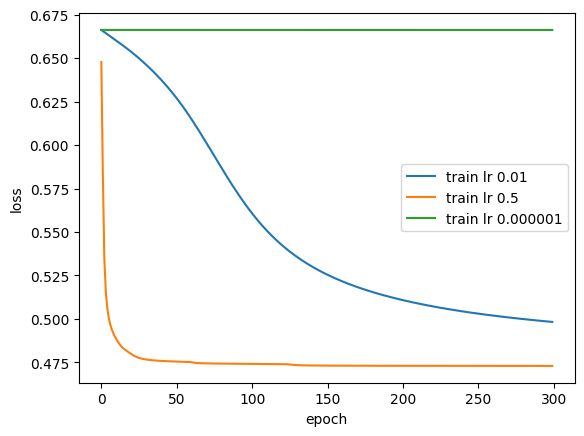

In [550]:
# No nos molestemos en graficar los de validación, solo harán más confuso el gráfico
plt.plot(range(EPOCHS), train_losses_lr001, label='train lr 0.01')
plt.plot(range(EPOCHS), train_losses_lr05, label='train lr 0.5')
plt.plot(range(EPOCHS), train_losses_lr0000001, label='train lr 0.000001')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


Waos!

El learning rate claramente afecta mucho más a la velocidad de aprendizaje del modelo (lo cual es de esperarse).

Para este caso, un learning rate más grande, de 0.5, ayudó a que el modelo aprenda considerablemente más rápido. Tan rápido que incluso llegó a un acc > 97%! Minimizó el loss a <0.5 incluso antes de los 50 epochs.

Por otro lado, 0.000001 es un learning rate demasiado pequeño. El modelo aprende demasiado lento, basicamente se mantuvo siempre con un loss de 0.666 y un acc de 61.28%.

Podemos ver que un learning rate grande nos ayuda a evitar el overfitting, ya que el modelo logra aprender suficientemente rápido, correrá menos riesgo de aprender patrones que solo apliquen a ciertos subconjuntos de datos en cada epoch, y por lo tanto, el modelo aprenderá patrones más generales, con respecto a todos los datos.

Por otro lado, si el learning rate es muy pequeño, vemos exactamente lo contrario, el modelo aprende muy lento, pasa mucho tiempo aprendiendo patrones de subconjuntos de datos chicos y poco tiempo aprendiendo patrones generales. Esto hace que el modelo se estanque en un loss alto, y que no pueda mejorar más.

# **Parte 4**
Implementar el algoritmo de gradiente descendente estocástico de manera que los mini-batches se generen de manera aleatoria antes de cada época. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [551]:
# ya sabemos que un learning rate de 0.5 es super rápido, pero para ser consistentes sigamos ocupando el de 0.01
LEARNING_RATE = 0.01
BATCH_SIZE = 20

In [568]:
# esta vez necesitamos que los mini batches se generen de forma aleatoria
# en torch, podemos pasarle shuffle=True al DataLoader para que haga shuffle de los datos dentro de cada batch
train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

In [569]:
# Ahora creamos el MLP y lo corremos como siempre
model = MLP(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    
  start_time = time.time()

  #Train + validation cycles  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  # save the losses for the plot later
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
    
  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')
    
  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.670 | Train Acc: 38.83%
	 Val. Loss: 0.604 |  Val. Acc: 25.00%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.669 | Train Acc: 38.83%
	 Val. Loss: 0.603 |  Val. Acc: 25.00%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.668 | Train Acc: 38.83%
	 Val. Loss: 0.752 |  Val. Acc: 56.67%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.667 | Train Acc: 38.98%
	 Val. Loss: 0.600 |  Val. Acc: 25.00%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 41.35%
	 Val. Loss: 0.599 |  Val. Acc: 25.00%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.665 | Train Acc: 43.50%
	 Val. Loss: 0.598 |  Val. Acc: 26.67%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 44.92%
	 Val. Loss: 0.599 |  Val. Acc: 35.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 53.23%
	 Val. Loss: 0.597 |  Val. Acc: 36.67%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 62.82%
	 Val. Loss: 0.752 |  Val. Acc: 76.67%
Epoch: 10 | Epoch Time: 0m 0

In [570]:
# guardamos los losses
train_losses_rand = train_losses
valid_losses_rand = valid_losses

In [571]:
# los losses de la P1 los tenemos guardados acá
train_losses_norand = train_losses_batch20
valid_losses_norand = valid_losses_batch20

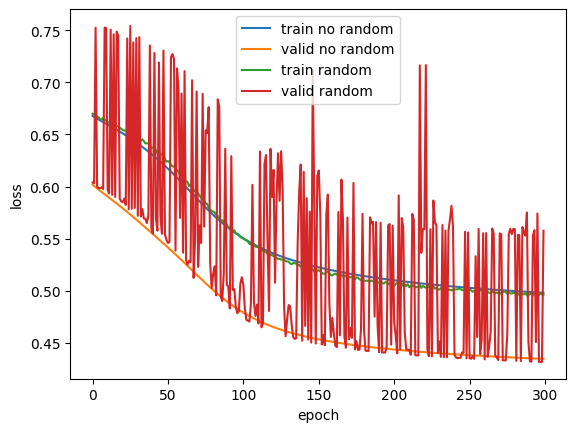

In [573]:
# plot
plt.plot(range(EPOCHS), train_losses_norand, label='train no random')
plt.plot(range(EPOCHS), valid_losses_norand, label='valid no random')
plt.plot(range(EPOCHS), train_losses_rand, label='train random')
plt.plot(range(EPOCHS), valid_losses_rand, label='valid random')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


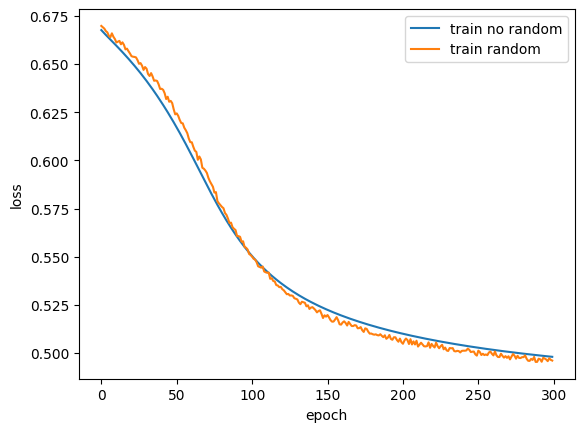

In [574]:
# yikes! saquemos los de validación para ver mejor
plt.plot(range(EPOCHS), train_losses_norand, label='train no random')
plt.plot(range(EPOCHS), train_losses_rand, label='train random')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

Vemos que con batches shuffleados, el modelo inicialmente aprende más lento, pero a partir de cierto punto, empieza a superar a la versión no aleatoria.

En particular, vemos que supera a la versión no aleatoria cerca del final, al acercarse al punto en donde antes se atascaba.

Esto tiene sentido si consideramos el porqué del estancamiento. Llegamos a un punto en donde el modelo ya no podía aprender más. Aunque siguieramos tirando epochs, el modelo a penas se movía. Este se debe a que en este punto, solo con los datos que tenemos, el modelo ya aprendió casi todo lo que podía aprender, y está empezando a aprender patrones que son específicos de los datos de entrenamiento, y no de la data en general. Es decir, nuevamente tenemos overfitting.

Al shufflear los batches, estamos haciendo que el modelo vea los datos en un orden diferente y más impredecible en cada epoch. Esto hace más dificil que aparezcan estos patrones pertenecientes a los datos de entrenamiento, pero que no son generales. Por lo tanto, es mucho menos probable que el modelo vea los mismos patrones en cada epoch, y por lo tanto, es menos probable que se estanque.

Eventualmente, el modelo se estancará de nuevo. A fin y a cabo tenemos datos finitos, por lo que volverá a haber overfitting. Pero al menos, el modelo habrá aprendido más antes de estancarse. Y esto es algo que podemos ver en la gráfica. Se estanca, pero más abaajo que la versión no aleatoria.

Notemos también el extraño comportamiento de los datos de validación. ¿Por qué saltan tanto? vemos que, más o menos, siguien la misma tendencia que los de validación no aleatorios (y todos los otros datos, de hecho), pero por qué están tan esparcidos?

Es de esperarse que la curva de loss vs epochs con shuffle de saltos, debido a su aletoriedad, pero entre más data ocupamos, más esperaríamos que se estabilice. Y recordemos que nuestros datos de validación con muy pocos. Solo son 41. Esto hace que sea más probable que los saltos sean más grandes, y por lo tanto, que la curva sea más irregular.

Esto nos deja con la pregunta: ¿Que pasa si no usamos validación?

In [575]:
X_train = train_dataset.to_numpy()
X_test = test_dataset.to_numpy()

Y_train = train_labels.to_numpy()
Y_test = test_labels.to_numpy()

Y_train = Y_train[:,None]
Y_test = Y_test[:,None]

train_data = list(zip(X_train, Y_train))
test_data = list(zip(X_test, Y_test))

In [576]:
train_iterator = data.DataLoader(train_data, shuffle=False, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE)

In [577]:
# Ahora creamos el MLP y lo corremos como siempre
model = MLP(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

train_losses = []

for epoch in range(EPOCHS):
    
  start_time = time.time()

  #Train with no validation  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)

  # save the losses for the plot later
  train_losses.append(train_loss)
    
  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.665 | Train Acc: 69.76%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 72.86%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.663 | Train Acc: 73.57%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.662 | Train Acc: 73.89%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.661 | Train Acc: 73.89%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.660 | Train Acc: 74.13%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.659 | Train Acc: 73.89%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.658 | Train Acc: 74.60%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.658 | Train Acc: 75.08%
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 0.657 | Train Acc: 75.32%
Epoch: 11 | Epoch Time: 0m 0s
	Train Loss: 0.656 | Train Acc: 75.56%
Epoch: 12 | Epoch Time: 0m 0s
	Train Loss: 0.655 | Train Acc: 75.56%
Epoch: 13 | Epoch Time: 0m 0s
	Train Loss: 0.654 | Train Acc: 75.56%
Epoch: 14 | Epoch Time: 0m 0s
	Train Loss: 0.653 | Train Acc: 75.56%
Epoch: 15 | Epoch Time: 0m 0s
	Tra

In [578]:
train_losses_novalid_norand = train_losses

In [579]:
train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

In [580]:
# Ahora creamos el MLP y lo corremos como siempre
model = MLP(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

train_losses = []

for epoch in range(EPOCHS):
    
  start_time = time.time()

  #Train with no validation  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)

  # save the losses for the plot later
  train_losses.append(train_loss)
    
  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.665 | Train Acc: 64.05%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.663 | Train Acc: 74.13%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 78.73%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.662 | Train Acc: 79.05%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.663 | Train Acc: 80.71%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.661 | Train Acc: 80.16%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.660 | Train Acc: 80.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.660 | Train Acc: 78.33%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.659 | Train Acc: 78.73%
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 0.658 | Train Acc: 77.70%
Epoch: 11 | Epoch Time: 0m 0s
	Train Loss: 0.657 | Train Acc: 77.86%
Epoch: 12 | Epoch Time: 0m 0s
	Train Loss: 0.656 | Train Acc: 77.94%
Epoch: 13 | Epoch Time: 0m 0s
	Train Loss: 0.656 | Train Acc: 77.14%
Epoch: 14 | Epoch Time: 0m 0s
	Train Loss: 0.656 | Train Acc: 77.06%
Epoch: 15 | Epoch Time: 0m 0s
	Tra

In [581]:
train_losses_novalid_rand = train_losses

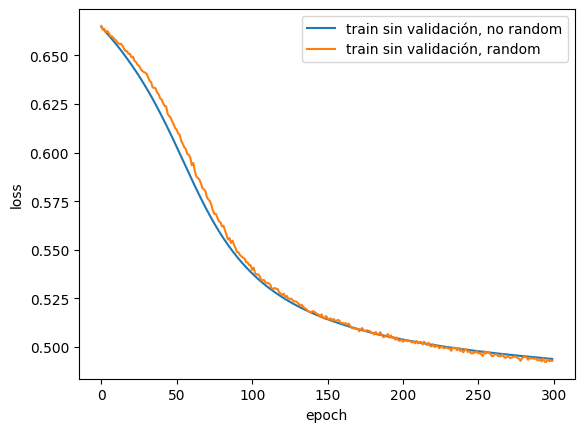

In [583]:
# plot
plt.plot(range(EPOCHS), train_losses_novalid_norand, label='train sin validación, no random')
plt.plot(range(EPOCHS), train_losses_novalid_rand, label='train sin validación, random')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

Vemos que, más o menos ocurre lo mismo, pero se demora un poco más en converger. Pero al igual que antes, inicialmente con shuffle es más lento, pero eventualmente toma la delantera, y termina con un loss menor, debido a que con shuffle es mejor evitando el overfitting.

Aunque vale destacar que la validación ciertamente lo ayuda a converger más rápido.